In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD




%load_ext tensorboard

Data Cleaning

In [2]:
data = pd.read_csv('data_file.csv') # pandas data frame

/var/folders/ys/6w09q22n4f73ds9jwmgbstjc0000gn/T/ipykernel_30008/3928255717.py:1: DtypeWarning: Columns (36,37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,207,208,209,210,211,212,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,292,293,294,295,296,299,301,302,303,306,332) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_file.csv') # pandas data frame


In [3]:




##preprocessing


##removes 
data = data.loc[(data['desc'].str.startswith('('))]
data = data[data['play_type'] != 'qb_kneel']
data = data[data['play_type'] != 'no_play']
data = data[data['posteam'] == 'NYJ']
data = data.dropna(subset=['down'])
data = data.dropna(subset=['play_type'])
data = data.dropna(subset=['wp'])
data = data[(data['play_type'] == 'pass') | (data['play_type'] == 'run') | (data['play_type'] == 'field_goal') | (data['play_type'] == 'punt')]
# Look into creating specific year and months, and training and testing on specific years/gmaes. 


# Extract year and month using string slicing
data['year'] = data['game_id'].str[:4].astype(int)
data['month'] = data['game_id'].str[5:7].astype(int)
##data = data[(data['year'] >= 2012) & (data['year'] <= 2020)]



# Create a new 'date' column with the 1st day of each extracted year and month


# Come back to this when we want to specify split spots  
# def parse_date(x):
#     parts = x.split('_')
#     year = int(parts[0])
#     month = int(parts[1])
#     print(month)
#     return pd.Timestamp(year=int(year), month=month), day=1)

# Apply the function to the 'game_date' column
# data['date'] = data['game_id'].apply(parse_date)
# # Now you can sort by this 'date' column if needed
# data.sort_values(by='date', inplace=True)

# # And use the 'date' column for splitting your data, work with in the future to pick specific dates 
# #Right now not working because the months in the game_id are 01-12, when for pd.TimeStamp they need to be in 1-12. 
# split_date = pd.Timestamp(year=2018, month=12, day=1)  # Replace YYYY and MM with your split year and month
# train_data = data[data['date'] < split_date]
# test_data = data[data['date'] >= split_date]

 
##fixes playtype to be strictly pass or run 
##lables scrambles as passes
data.loc[data['pass']==1,'play_type'] = 'pass'
data.loc[data.rush==1,'play_type'] = 'run'

# columns are the strings 
# things to encode from strings to 1s and zeros
# season_type, 
columnsKeep = ['game_id', 'score_differential_post','year','month','season_type','week','posteam','posteam_type','defteam','side_of_field','yardline_100','half_seconds_remaining','home_team','away_team',
               'game_seconds_remaining','game_half','drive','down','time','yrdln','ydstogo','desc','play_type','yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel',
               'qb_spike','qb_scramble','pass_length','run_location','run_gap','home_timeouts_remaining','away_timeouts_remaining','total_home_score','total_away_score',
               'passer_player_name','receiver_player_name','rusher_player_name','play_type_nfl','roof','surface','temp','wind','home_coach','away_coach','game_stadium',
               'success', 'wp','td_prob','safety_prob','fg_prob','qtr','month']

data = data[columnsKeep]







In [4]:
data.head(10)

,game_id,score_differential_post,year,month,season_type,week,posteam,posteam_type,defteam,side_of_field,...,home_coach,away_coach,game_stadium,success,wp,td_prob,safety_prob,fg_prob,qtr,month
1688,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NYJ,...,Bill Parcells,Pete Carroll,Giants Stadium,1.0,0.511088,0.337055,0.004105,0.224790,1,1
1689,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NYJ,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.540658,0.400083,0.005173,0.269057,1,1
1691,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NYJ,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.515651,0.360900,0.006034,0.216581,1,1
1692,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NYJ,...,Bill Parcells,Pete Carroll,Giants Stadium,1.0,0.483294,0.313050,0.006317,0.183432,1,1
1693,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.568891,0.435921,0.005053,0.304493,1,1
1694,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.585828,0.421748,0.005522,0.312676,1,1
1695,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.559873,0.373031,0.006385,0.290889,1,1
1696,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,1.0,0.527776,0.324106,0.012622,0.213141,1,1
1697,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,1.0,0.613332,0.464778,0.004886,0.341521,1,1
1698,1999_01_NE_NYJ,-3.0,1999,1,REG,1,NYJ,home,NE,NE,...,Bill Parcells,Pete Carroll,Giants Stadium,0.0,0.606414,0.453197,0.002704,0.387664,1,1


In [5]:

# Assuming 'data' is your DataFrame

def pos_coach(row):
    if row['posteam_type'] == 'home':
        return row["home_coach"]
    elif row['posteam_type'] == 'away':
        return row["away_coach"]
    else:
        return None  # or any default value if needed
    

data['pos_coach'] = data.apply(pos_coach, axis=1)






In [6]:
le = LabelEncoder()
data['pos_coach'] = le.fit_transform(data['pos_coach'])
data['defteam'] = le.fit_transform(data['defteam'])


In [7]:
print(len(data))

# Count occurrences of each play type
runCount = (data['play_type'] == 'run').sum()
passCount = (data['play_type'] == 'pass').sum()
fgCount = (data['play_type'] == 'field_goal').sum()
puntCount = (data['play_type'] == 'punt').sum()


print("Number of 'run' plays:", runCount)
print("Number of 'pass' plays:", passCount)
print("Number of 'field goal' plays:", fgCount)
print("Number of 'punt' plays:", puntCount)



28435
Number of 'run' plays: 10808
Number of 'pass' plays: 14749
Number of 'field goal' plays: 825
Number of 'punt' plays: 2053


In [8]:
##check for nan values in data
for index, row in data.iterrows():
    if pd.isnull(row['play_type']):  # Check if the value in the 'down' column is NaN
        print(row['desc'])  # Print the value in the 'desc' column if 'down' is NaN

# wind and stadium had a lot of null 
## check for missing values in data
features = data[['down','qtr','score_differential_post','pos_coach','defteam','drive', 'ydstogo','yardline_100', 'half_seconds_remaining', 'wp','week','td_prob','fg_prob','safety_prob','qtr','month']]
missing_values_features = data[features].isnull().sum()
print("Missing values in selected features:")
print(missing_values_features)

# Check for missing values in the target
missing_values_target = data['play_type'].isnull().sum()
print("\nMissing values in target (play_type):", missing_values_target)


ValueError: Boolean array expected for the condition, not int64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = data[['down','qtr','score_differential_post','pos_coach','defteam','drive', 'ydstogo','yardline_100', 'half_seconds_remaining', 'wp','week','td_prob','fg_prob','safety_prob','qtr','month']]
##features = data[['down','qtr','score_differential_post','pos_coach','defteam','drive', 'ydstogo','yardline_100', 'half_seconds_remaining', 'wp','week']]

target = data['play_type'].map({'pass': 0, 'run': 1, 'field_goal':2,'punt':3})

# Initialize the scaler 
scaler = StandardScaler() 

# Fit the scaler on the features and transform them 
features_scaled = scaler.fit_transform(features)

# Reshaping input data for LSTM [samples, time steps, features]
# Here, we assume each sample is a single time step
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Talk to Nicolai and Ulrich if they think this is a good idea to split it up into drives as our time stamp. 
# 1 indicates that each sample consists of 1 timestep. This is a key detail: 
# it means you are treating each play as a separate, single-timestep sequence. T
# This is a simplification, as ideally, plays within a single drive might be treated as sequences to capture their temporal dependencies.

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle = False)




In [10]:
# Initalizing Model
model = Sequential([
    # Adding input layer; input_shape corresponds to (time_steps, features)
    LSTM(32, return_sequences=True, input_shape=(1, features_scaled.shape[2])),
    # Dropout to avoid overfitting
    Dropout(0.2),
    # Adding to a second LSTM Layer 
    LSTM(16,return_sequences=False),
    Dropout(0.2),
    #Adding the output layer, since multiple classification (pass/run/field goal/punt) use softmax function
    Dense(4, activation='softmax')
])
# compile the model using the training data 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Training the model using the training data 
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Evaluating our model, printing accuracy 
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}')

2024-07-01 12:57:13.257558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-01 12:57:13.258390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-01 12:57:13.258720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-07-01 12:57:13.463123: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-07-01 12:57:13.561570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-01 12:57:13.562115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-01 12:57:13.562643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

625/640 [============================>.] - ETA: 0s - loss: 0.8208 - accuracy: 0.6008

2024-07-01 12:57:15.055410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-01 12:57:15.055896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-01 12:57:15.056374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

640/640 [==============================] - 2s 1ms/step - loss: 0.8165 - accuracy: 0.6021 - val_loss: 0.5918 - val_accuracy: 0.6949
Epoch 2/50
640/640 [==============================] - 0s 750us/step - loss: 0.6017 - accuracy: 0.6831 - val_loss: 0.5543 - val_accuracy: 0.7143
Epoch 3/50
640/640 [==============================] - 0s 742us/step - loss: 0.5821 - accuracy: 0.6924 - val_loss: 0.5409 - val_accuracy: 0.7174
Epoch 4/50
640/640 [==============================] - 0s 741us/step - loss: 0.5727 - accuracy: 0.6951 - val_loss: 0.5322 - val_accuracy: 0.7191
Epoch 5/50
640/640 [==============================] - 0s 717us/step - loss: 0.5661 - accuracy: 0.6985 - val_loss: 0.5246 - val_accuracy: 0.7231
Epoch 6/50
640/640 [==============================] - 0s 718us/step - loss: 0.5617 - accuracy: 0.7011 - val_loss: 0.5239 - val_accuracy: 0.7257
Epoch 7/50
640/640 [==============================] - 0s 716us/step - loss: 0.5547 - accuracy: 0.7029 - val_loss: 0.5201 - val_accuracy: 0.7305
Epoch

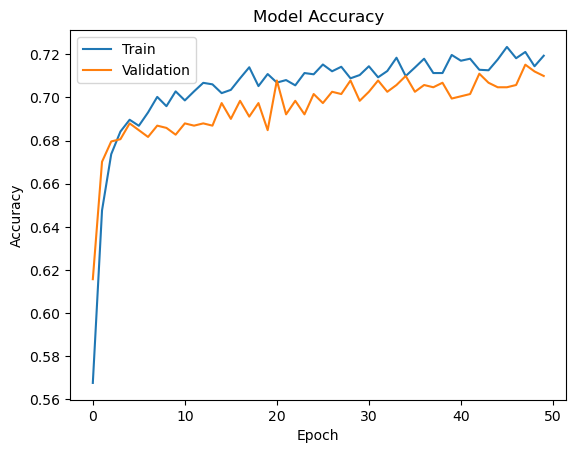

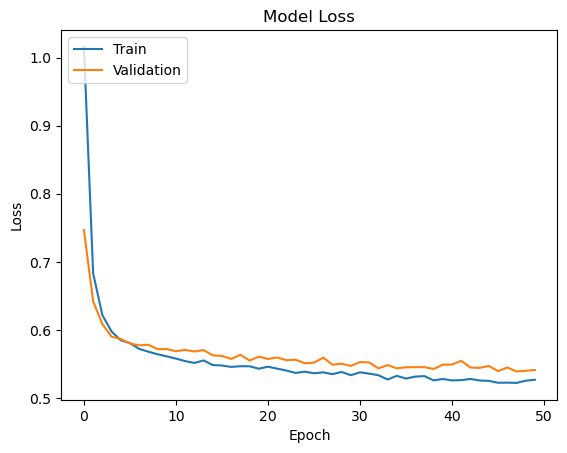

In [18]:

import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_classes))


75/75 [==============================] - 0s 356us/step


2024-05-06 21:02:04.014168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-06 21:02:04.014609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-06 21:02:04.015421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      1226
           1       0.70      0.42      0.53       947
           2       0.93      1.00      0.96        67
           3       0.97      0.99      0.98       146

    accuracy                           0.69      2386
   macro avg       0.81      0.82      0.80      2386
weighted avg       0.70      0.69      0.68      2386

Confusion Matrix:
[[1045  176    3    2]
 [ 540  402    2    3]
 [   0    0   67    0]
 [   2    0    0  144]]


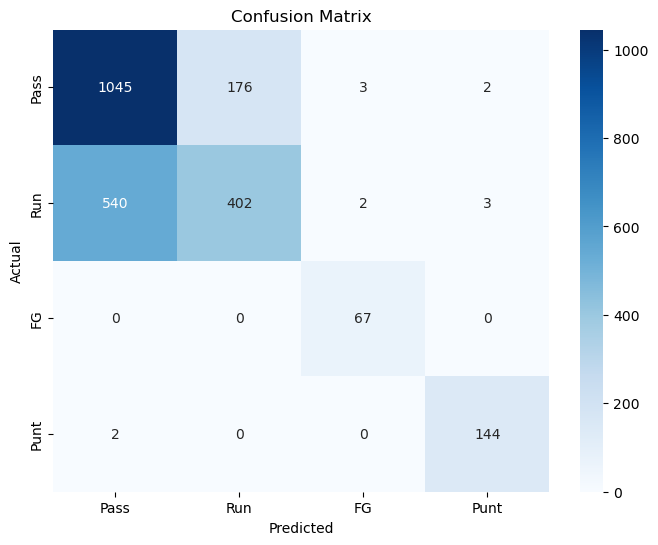

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pass', 'Run', 'FG','Punt'],
            yticklabels=['Pass', 'Run', 'FG','Punt'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:

data['play_type'] = data['play_type'].map({'pass': 0, 'run': 1, 'field_goal':2,'punt':3})

features = data[['play_type','down','qtr','score_differential_post','pos_coach','defteam','drive', 'ydstogo','yardline_100', 'half_seconds_remaining', 'wp','week','td_prob','fg_prob','safety_prob','qtr','month']]
dummies = pd.get_dummies(features, prefix='play_type')

newdf = pd.concat([features, dummies], axis=1)






/Users/sammozer/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/sammozer/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


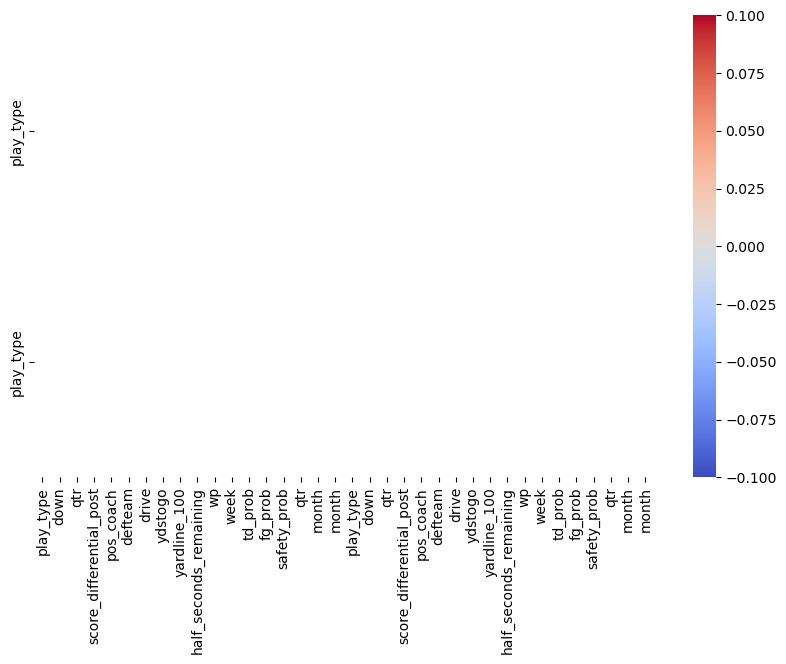

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

corr_matrix = newdf.corr()
newcorr = corr_matrix[['play_type']].transpose()

sns.heatmap(newcorr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.show()

In [15]:
# length of X train, and nulls in the x,train, x_test, y_train, y_test 
print(len(X_train))
nan_indices_X = np.isnan(X_train)
nan_count_X = np.sum(nan_indices_X)
print(nan_count_X)

nan_indices_X_test = np.isnan(X_test)
nan_count_X_test = np.sum(nan_indices_X_test)
print(nan_count_X_test)

nan_indices_y = np.isnan(y_train)
nan_count_y = np.sum(nan_indices_y)
print(nan_count_y)

nan_indices_Y_test = np.isnan(y_test)
nan_count_Y_test = np.sum(nan_indices_Y_test)
print(nan_count_Y_test)

print("Shape of X_train:", X_train.shape)

739764
0
0
0
0
Shape of X_train: (739764, 1, 7)
